In [31]:
import pandas as pd
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [17]:
# File paths for sensor data and target labels
X_train = 'D:/Python/Hydraulic Rig Dataset/Data/X_train_before_rockets.pkl'
X_test ='D:/Python/Hydraulic Rig Dataset/Data/X_test_before_rockets.pkl'
y_train = 'D:/Python/Hydraulic Rig Dataset/Data/y_train_pickled.pkl'
y_test ='D:/Python/Hydraulic Rig Dataset/Data/y_test_pickled.pkl'


X_train = pd.read_pickle(X_train)
X_test = pd.read_pickle(X_test)
y_train = pd.read_pickle(y_train)
y_test = pd.read_pickle(y_test)





In [18]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f'Before SMOTE: {Counter(y_train)}')
print(f' After SMOTE: {Counter(y_train_res)}')

Before SMOTE: Counter({0: 1155, 1: 609})
 After SMOTE: Counter({0: 1155, 1: 1155})


In [22]:
# ------------------------------------------------------------------
# 1)  base sensor list & expected length  ---------------------------
# ------------------------------------------------------------------
BASE_SENSORS = [
    "PS1","PS2","PS3","PS4","PS5","PS6",
    "EPS1","FS1","FS2",
    "TS1","TS2","TS3","TS4",
    "VS1","CE","CP","SE"
]
L = 60   # time steps per channel

# ------------------------------------------------------------------
# 2)  reshape helper (robust to extra columns)  --------------------
# ------------------------------------------------------------------
def reshape_for_minirocket(df, base_sensors, L=60, verbose=False):
    """
    df: wide DataFrame with columns like SENSOR_1 … SENSOR_60 plus extras
    returns: ndarray (n_samples, n_channels, L)
    """
    n_samples  = df.shape[0]
    n_channels = len(base_sensors)
    arr        = np.full((n_samples, n_channels, L), np.nan, dtype=np.float32)

    # regex: SENSOR_<integer>
    pat = re.compile(rf"^({'|'.join(map(re.escape, base_sensors))})_(\d+)$")

    for ch, sensor in enumerate(base_sensors):
        # collect & sort only true timestep columns
        cols = [c for c in df.columns if pat.match(c) and c.startswith(f"{sensor}_")]
        cols.sort(key=lambda s: int(s.split('_')[1]))  # numeric order

        if verbose:
            print(f"{sensor}: {len(cols)} columns")

        if cols:
            data = df[cols].to_numpy(dtype=np.float32)
            arr[:, ch, :data.shape[1]] = data[:, :L]   # right-pad with NaN

    return arr


# ------------------------------------------------------------------
# 3)  create (n_samples, n_channels, L) arrays  ---------------------
# ------------------------------------------------------------------
X_train_3d = reshape_for_minirocket(X_train, BASE_SENSORS, L)
X_test_3d  = reshape_for_minirocket(X_test,  BASE_SENSORS, L)

print("X_train_3d shape:", X_train_3d.shape)
print("X_test_3d  shape:", X_test_3d.shape)

X_train_3d shape: (1764, 17, 60)
X_test_3d  shape: (441, 17, 60)


In [24]:
# Apply MiniROCKET (multivariate version)
rocket = MiniRocketMultivariate(num_kernels=10000)
rocket.fit(X_train_3d)
X_train_transformed = rocket.transform(X_train_3d)
X_test_transformed = rocket.transform(X_test_3d)

print(X_train_transformed.shape)
print(X_test_transformed.shape)

(1764, 9996)
(441, 9996)


In [25]:
# Scale the Rocket features to [0, 1] range for downstream models
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

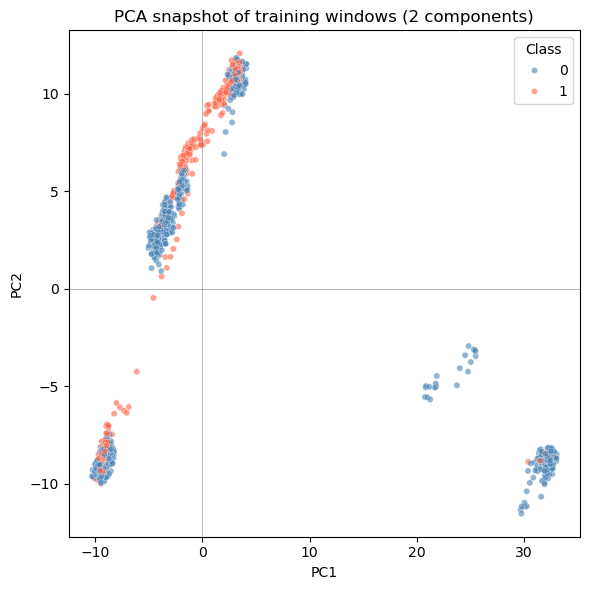

In [27]:
pca = PCA(n_components=2, random_state=1)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# 1.  Build a dataframe for easier plotting
pca_df = (
    pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
      .assign(Target=y_train.reset_index(drop=True))
)

# 2.  Scatter-plot
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Target",
    palette={0: "steelblue", 1: "tomato"},
    alpha=0.6, s=20
)
plt.axhline(0, lw=.4, color="grey"); plt.axvline(0, lw=.4, color="grey")
plt.title("PCA snapshot of training windows (2 components)")
plt.legend(title="Class", loc="best")
plt.tight_layout()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1764 samples in 0.013s...
[t-SNE] Computed neighbors for 1764 samples in 0.502s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1764
[t-SNE] Computed conditional probabilities for sample 1764 / 1764
[t-SNE] Mean sigma: 3.168089
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.526108
[t-SNE] KL divergence after 2000 iterations: 0.349240


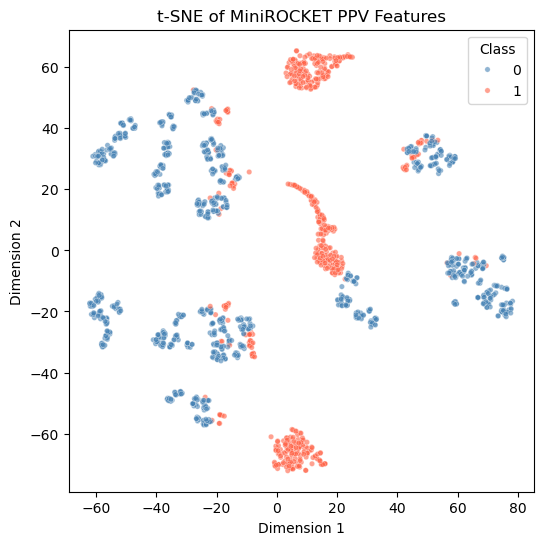

In [30]:
# 1) Determine sample size safely
n_rows = X_train_scaled.shape[0]
sample_size = min(5000, n_rows)       # if you have <5000 windows, just use them all

# 2) Subsample (without replacement)
rng = np.random.RandomState(0)
idx = rng.choice(n_rows, size=sample_size, replace=False)
X_sub = X_train_scaled[idx]
y_sub = y_train.values[idx]

# 3) Run t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=2000,
    init="pca",
    random_state=0,
    verbose=1
)
X_emb = tsne.fit_transform(X_sub)

# 4) Plot
df_emb = pd.DataFrame(X_emb, columns=["Dim1","Dim2"])
df_emb["Class"] = y_sub

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_emb,
    x="Dim1", y="Dim2",
    hue="Class",
    palette={0:"steelblue",1:"tomato"},
    alpha=0.6, s=15
)
plt.title("t-SNE of MiniROCKET PPV Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Class")
plt.show()


         total  faults    purity
cluster                         
0          255     168  0.658824
1           10       0  0.000000
2           90       9  0.100000
3          172      23  0.133721
4          174       7  0.040230
5          132      30  0.227273
6          145     145  1.000000
7          166     166  1.000000
8           98       0  0.000000
9           92       0  0.000000
10          98       0  0.000000
11          74       0  0.000000
12          69      19  0.275362
13         179      42  0.234637
14          10       0  0.000000


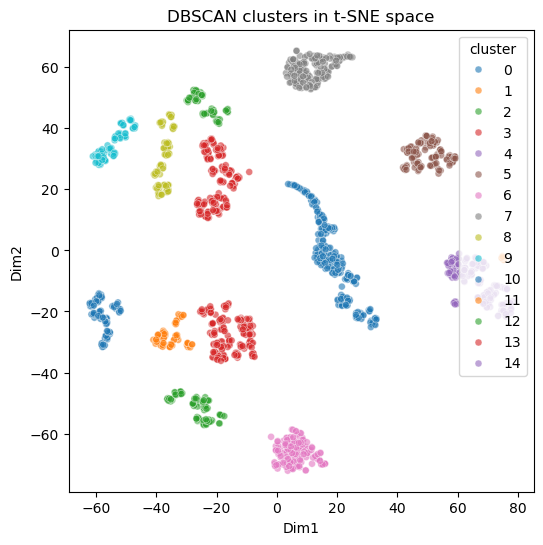

In [32]:

# 1) Cluster in t-SNE space ------------------------------------------------
# X_emb: array shape (n_sub,2), df_emb has Dim1, Dim2, Class
db = DBSCAN(eps=5, min_samples=10).fit(X_emb)
df_emb["cluster"] = db.labels_  # -1 = noise

# 2) Profile clusters for class purity ------------------------------------
cluster_summary = (
    df_emb.groupby("cluster")["Class"]
          .agg(total="size", faults=lambda s: s.sum())
          .assign(purity=lambda d: d["faults"]/d["total"])
)
print(cluster_summary)

# 3) Plot clusters --------------------------------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_emb, x="Dim1", y="Dim2",
                hue="cluster", palette="tab10", s=25, alpha=0.6)
plt.title("DBSCAN clusters in t-SNE space")
plt.show()

In [47]:
# Save the processed datasets and labels to disk for later use
X_train_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/X_train_pickled_smote.pkl'
X_test_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/X_test_pickled_smote.pkl'
y_train_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/y_train_pickled_smote.pkl'
y_test_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/y_test_pickled_smote.pkl'

X_train_transformed.to_pickle(X_train_pickled)  # save train features
X_test_transformed.to_pickle(X_test_pickled)     # save test features
y_train_res.to_pickle(y_train_pickled)               # save train labels
y_test.to_pickle(y_test_pickled)     # save test labels
